<a href="https://colab.research.google.com/github/RahulS247/Object-Localization/blob/main/Deep_Learning_with_PyTorch_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization

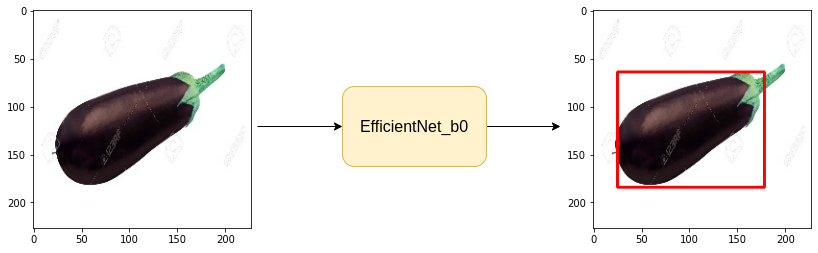

In [1]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-346c0wsj
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-346c0wsj
  Resolved https://github.com/albumentations-team/albumentations to commit 0cb8de5022a484e4586ce573040fc6e58885b094
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 26.3 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.1-py3-none-any.whl size=132541 sha256=75438f3ee5ace57f03ef2dce72b1de7764b642acdfba4a216582477f7442be08
  Stored in directory: /tmp/pip-ephem-wheel-cache-69i9j_ms/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: scik

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [5]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [7]:
CSV_file = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 16
IMG_SIZE = 140

LR =0.001
EPOCHS = 40
MODEL_NAME ='efficientnet_b0'

NUM_COR = 4

In [29]:
df = pd.read_csv(CSV_file)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

In [18]:
DATA_DIR+'/'+row.img_path

'/content/object-localization-dataset/train_images/mushroom_20.jpg'

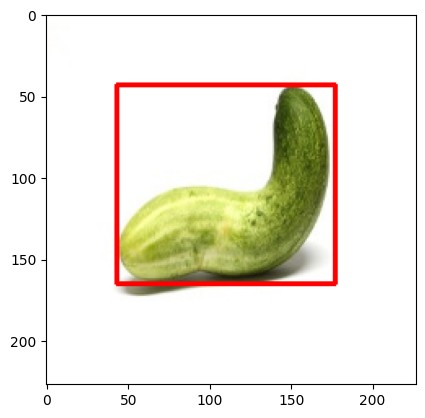

In [38]:
row = df.iloc[108]
img = cv2.imread(DATA_DIR+'/'+row.img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img=cv2.rectangle(img,pt1, pt2,(255,0,0),2)
plt.imshow(bnd_box_img)

In [41]:
len(df)

186

In [42]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
len(train_df), len(valid_df)

(148, 38)

# Augmentations

In [43]:
import albumentations as A

In [46]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))

# Create Custom Dataset

In [59]:
from torch.utils.data import Dataset, DataLoader
class ObjLocDataset(Dataset):
  def __init__(self,df,DATA_DIR,augmentations=None):
    self.df =df
    self.DATA_DIR = DATA_DIR
    self.augmentations = augmentations

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    xmin=row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax
    bbox=[[xmin,ymin,xmax,ymax]]

    imgpath = self.DATA_DIR+'/'+ row.img_path
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2,0,1)/255.0
    bbox = torch.Tensor(bbox)

    return img, bbox

  def __len__(self):
    return len(self.df)

In [60]:
trainset = ObjLocDataset(train_df,DATA_DIR,train_augs)
validset= ObjLocDataset(valid_df,DATA_DIR,valid_augs)

In [61]:
len(trainset), len(validset)

(148, 38)

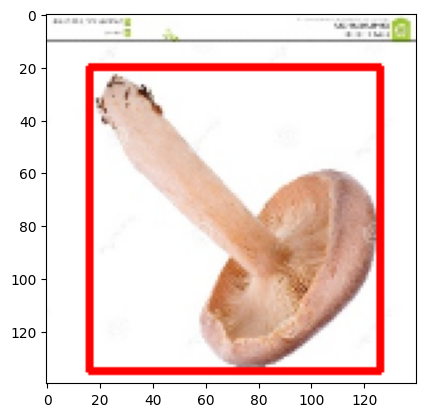

In [67]:
img, bbox = trainset[120]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [68]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE,shuffle=False)

In [69]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [70]:
for images, bboxes in trainloader:
  break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm

# Create Train and Eval Function

#Training Loop

#Inference

In [ ]:
import utils

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya